In [1]:
cd ../..

/Users/joeranbosma/stack/Projects/M5Forecast


In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from IPython.display import clear_output

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (get_chronological_train_val_split, get_train_val_slit, train_lightgbm_model,
                   plot_lgb_metrics, plot_result_list)
# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Train LightGBM - multiple levels - 5-fold chronological cross-validation

In [4]:
model_dir = 'models/uncertainty/train_lightgbm_events/run1/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [5]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'mae',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'colsample_bytree': 0.75}

augment_events = True
early_stopping_rounds = 250

## Perform training scheme

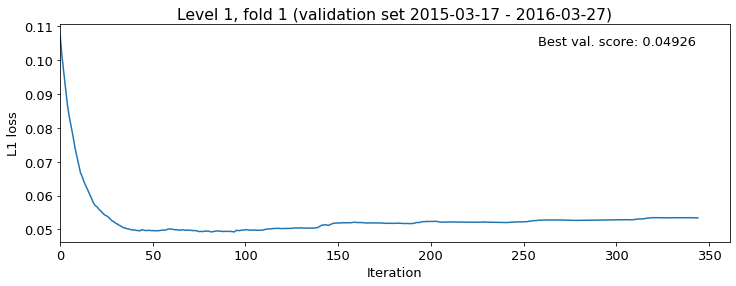

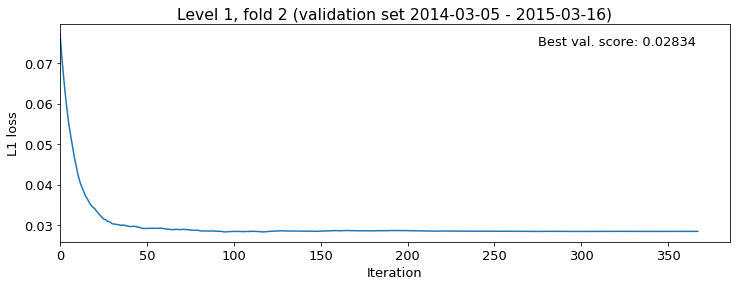

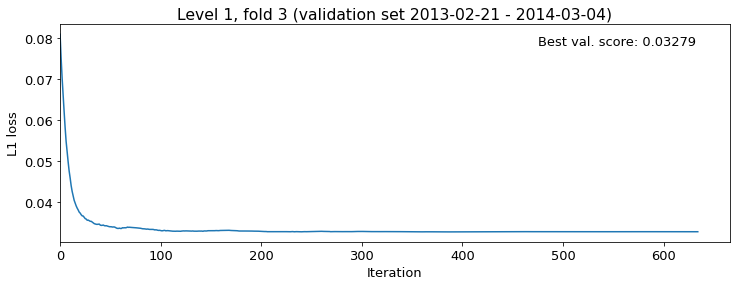

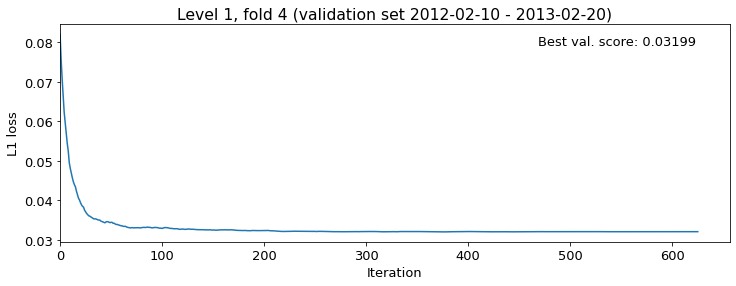

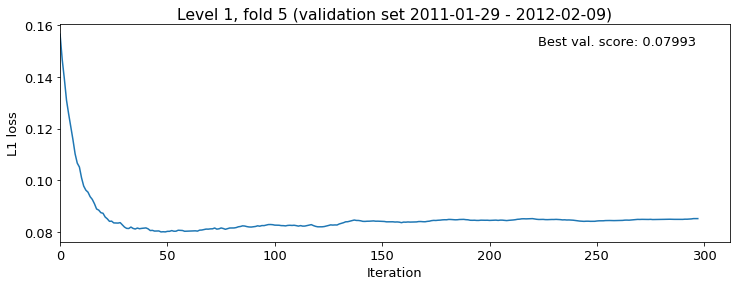

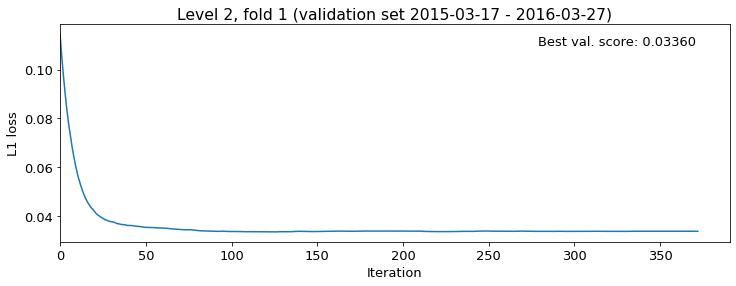

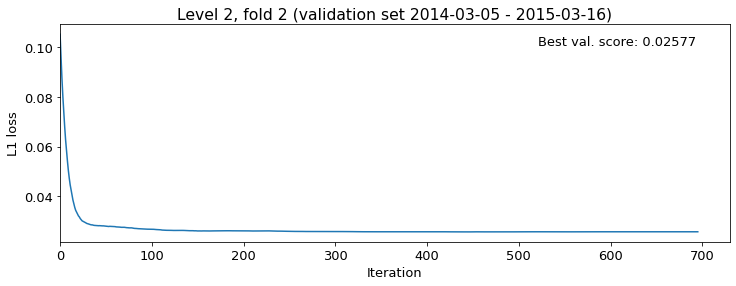

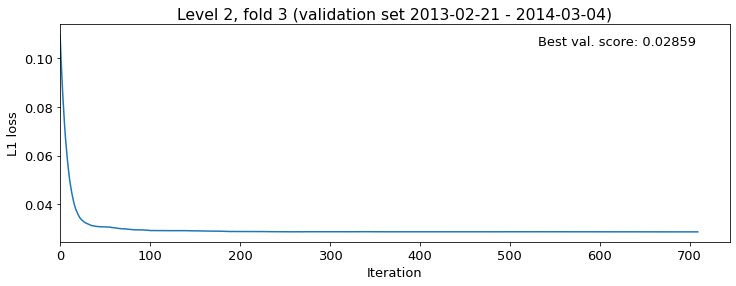

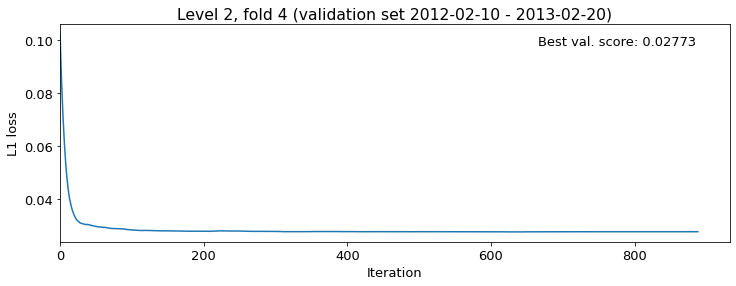

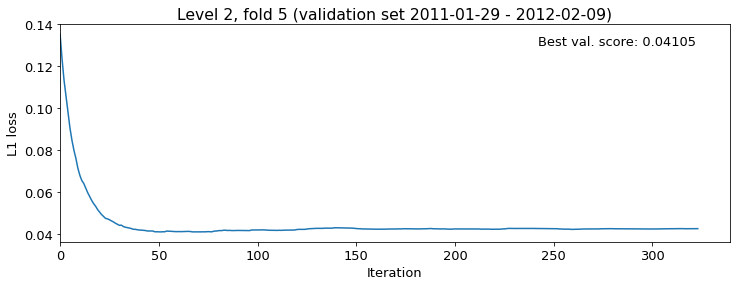

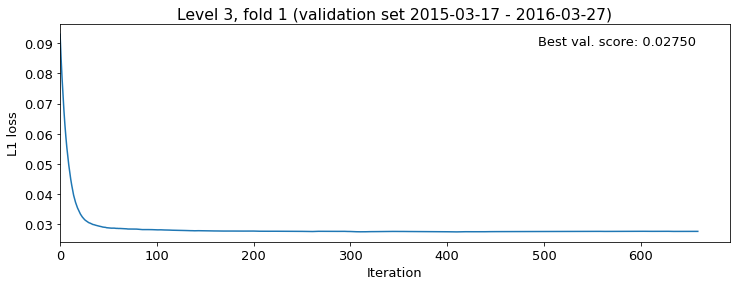

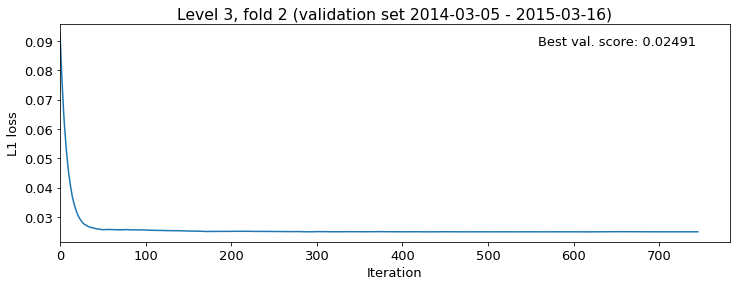

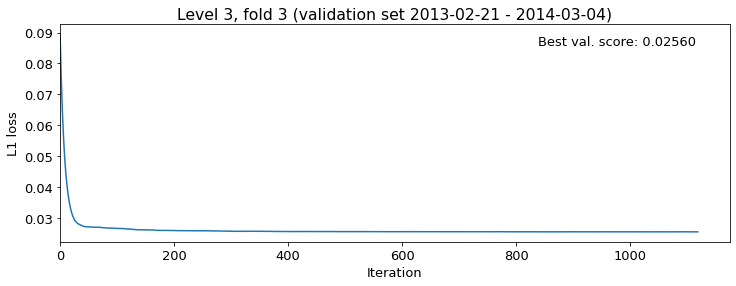

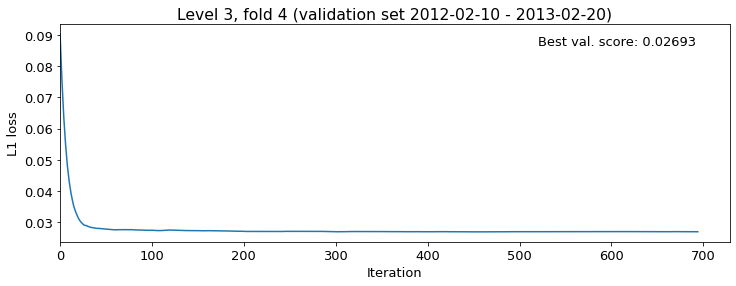

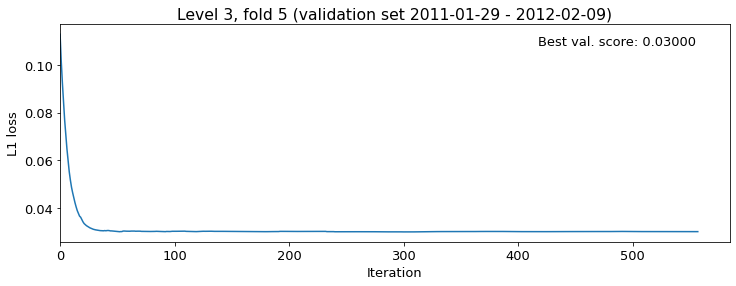

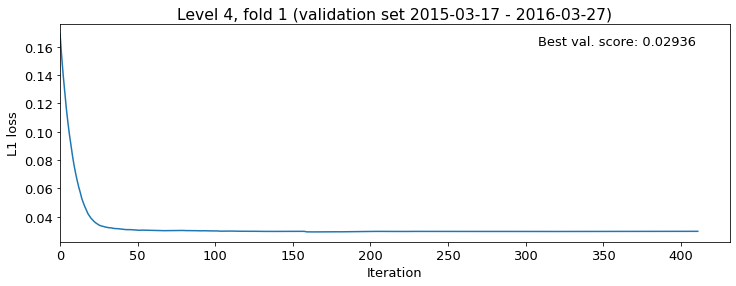

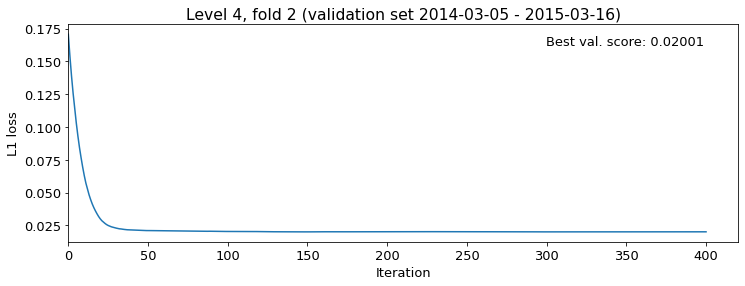

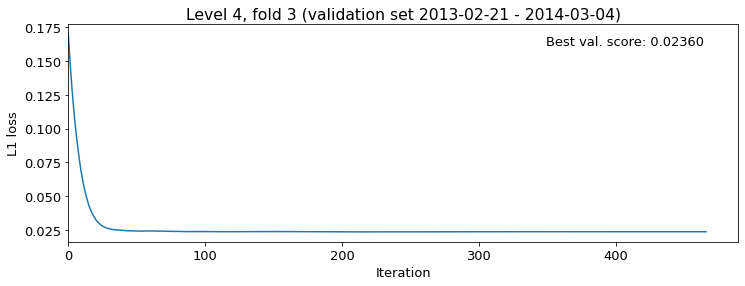

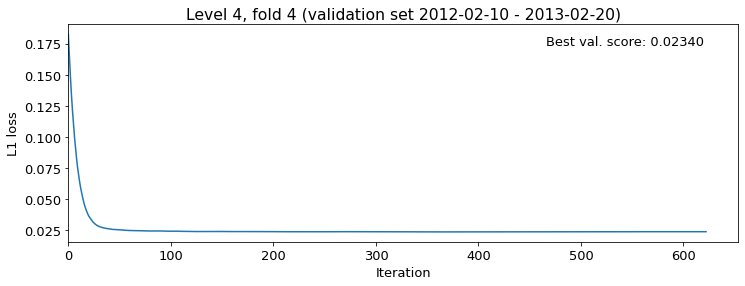

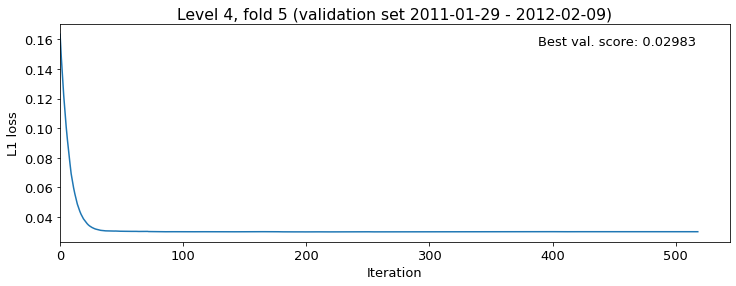

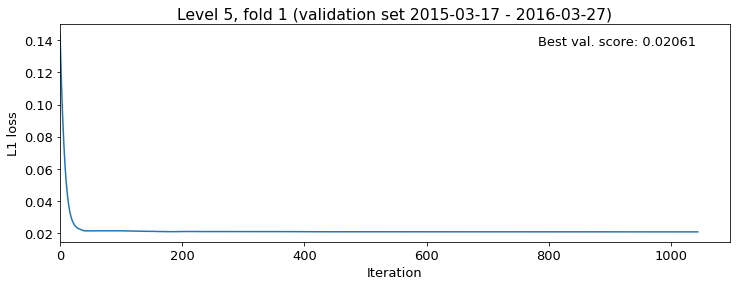

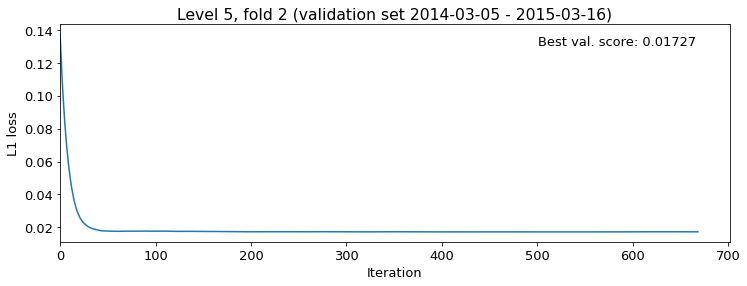

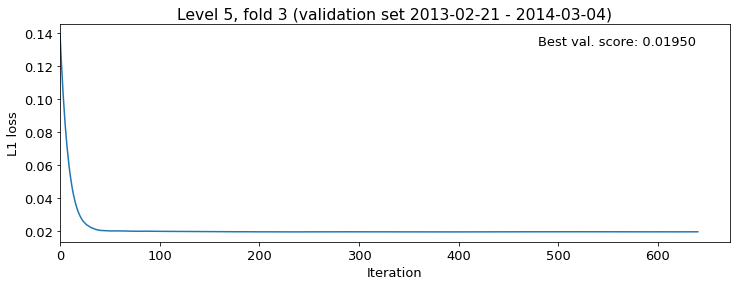

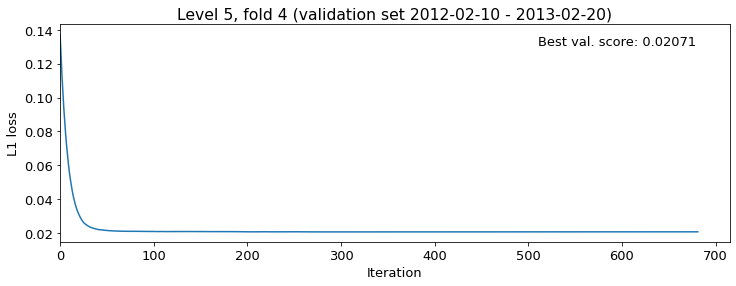

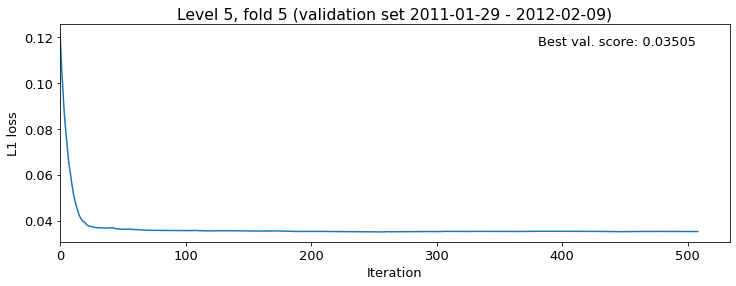

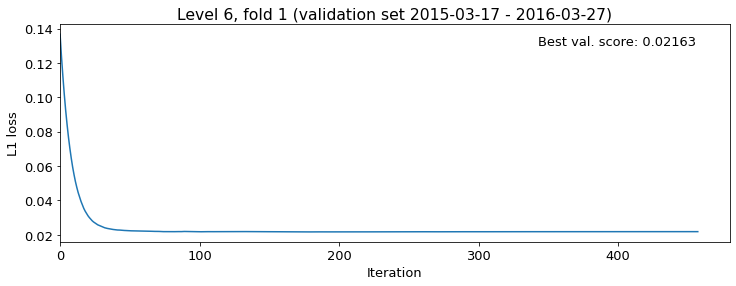

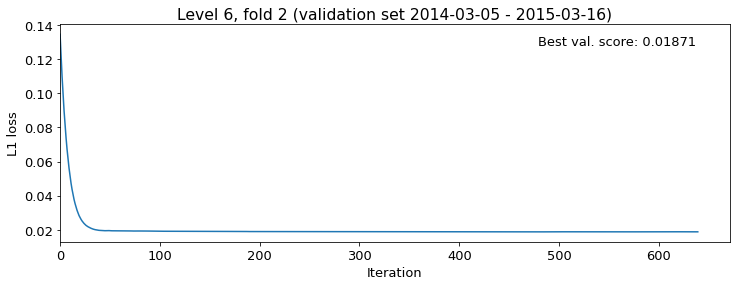

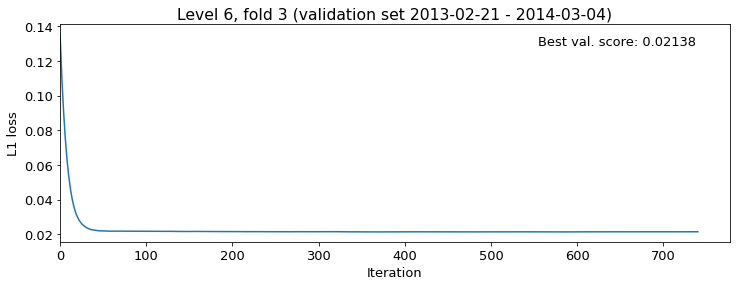

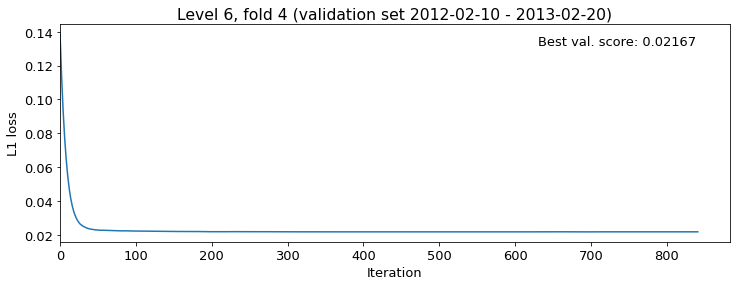

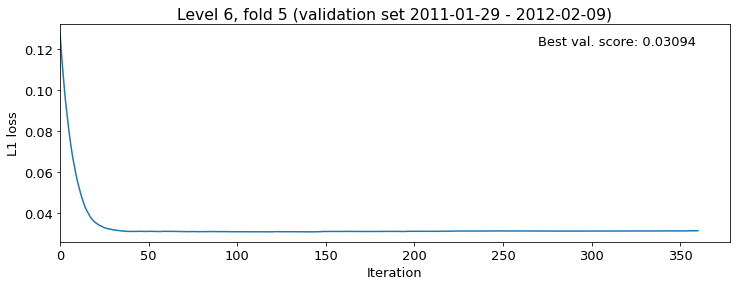

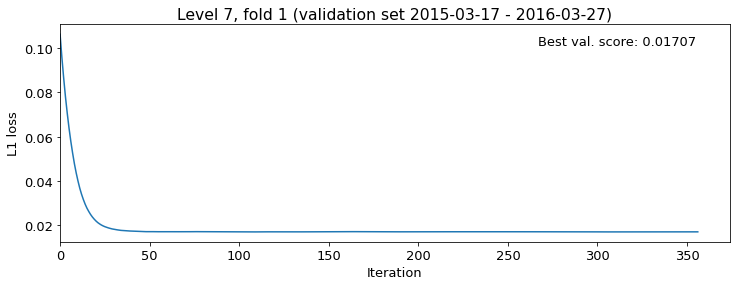

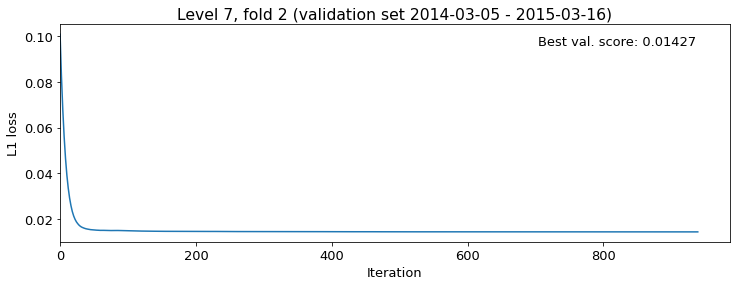

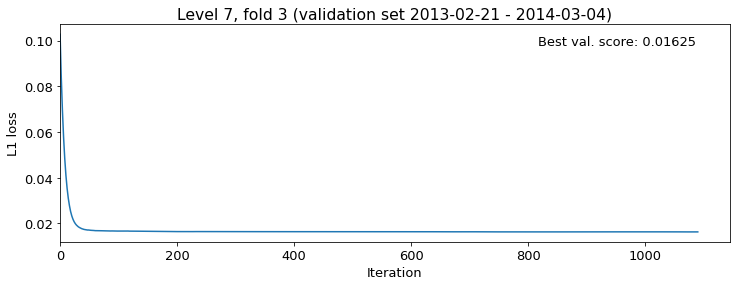

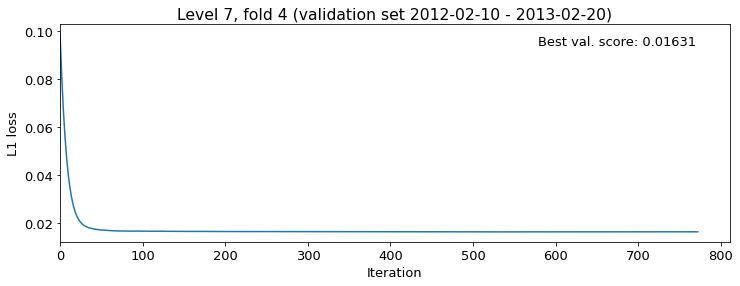

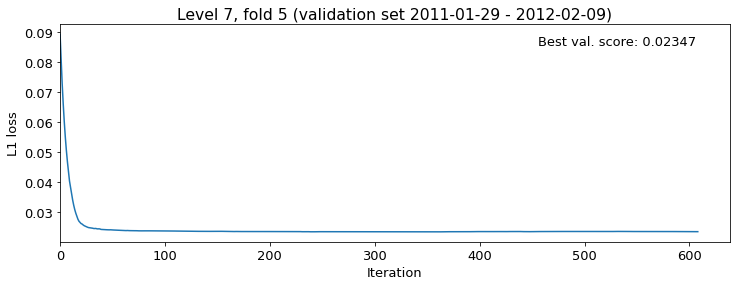

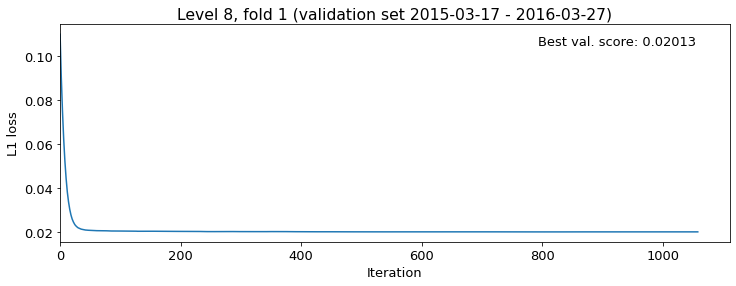

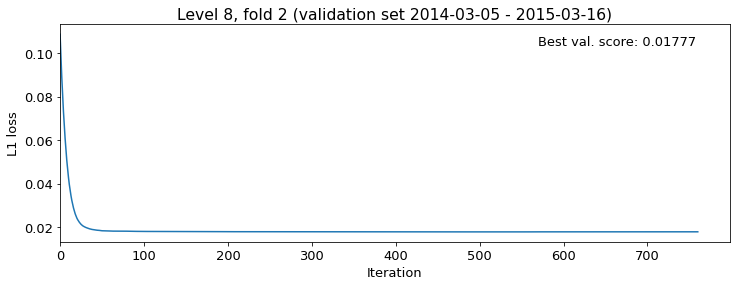

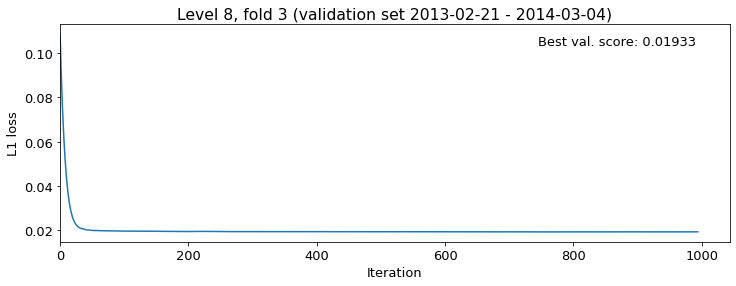

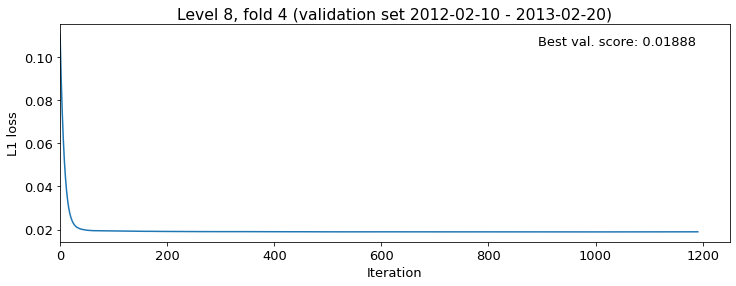

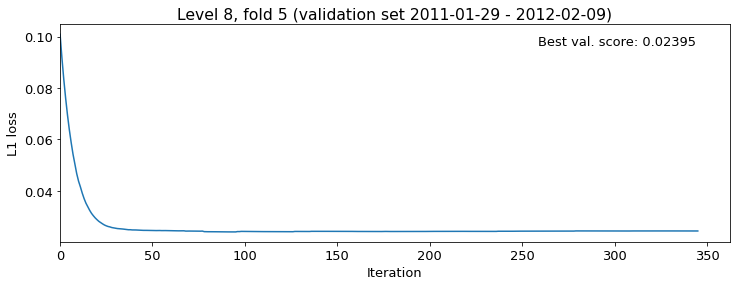

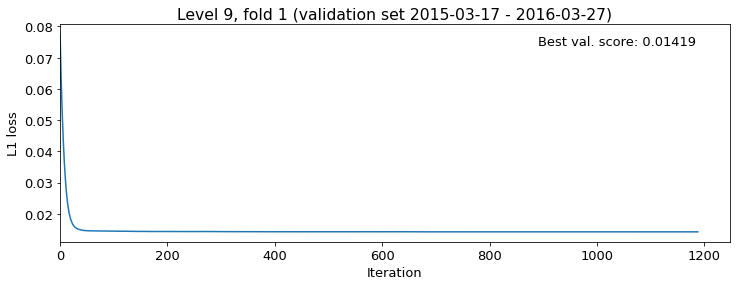

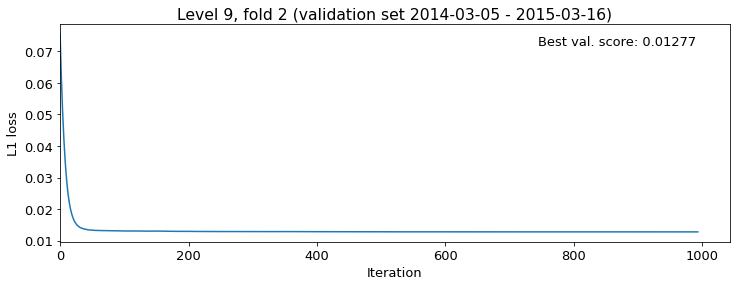

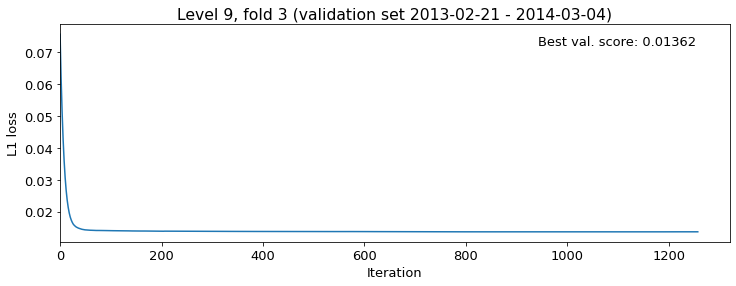

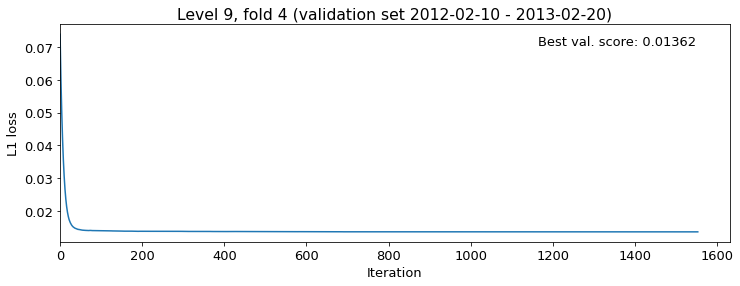

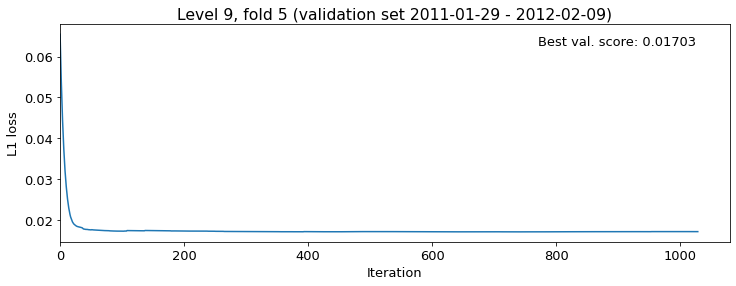

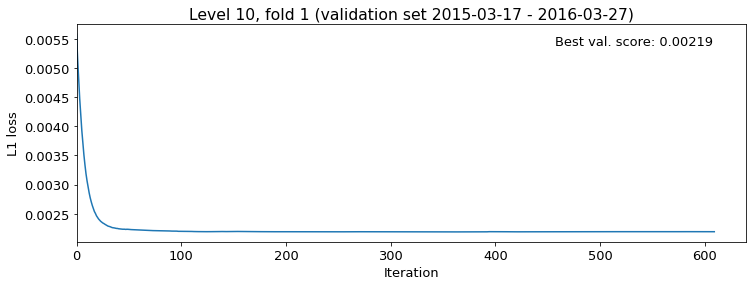

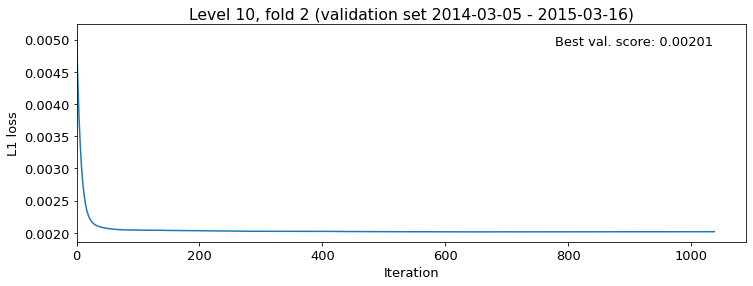

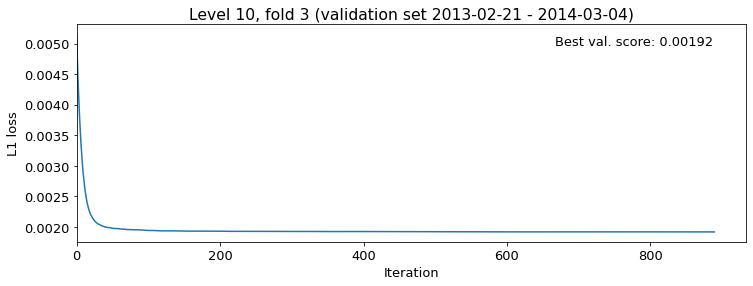

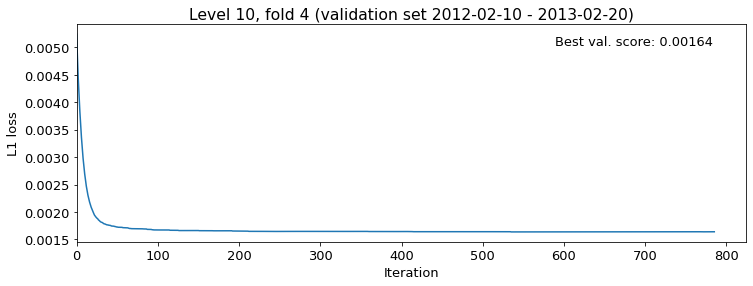

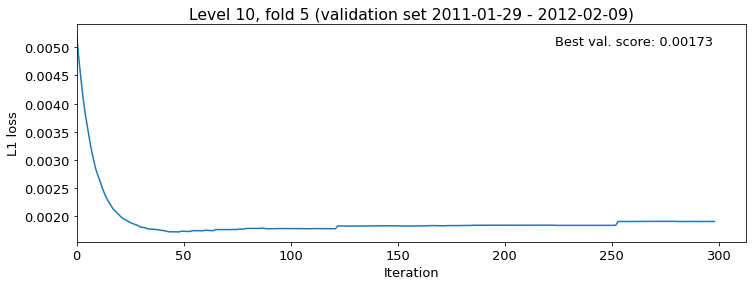

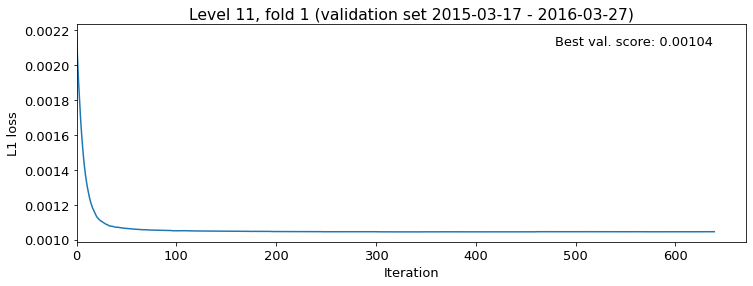

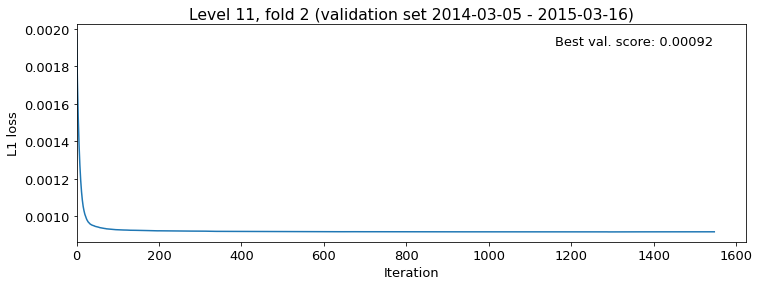

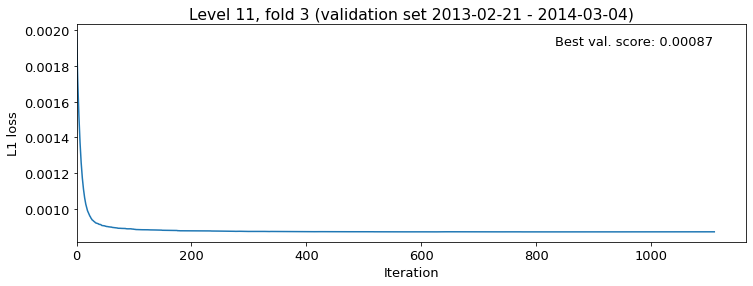

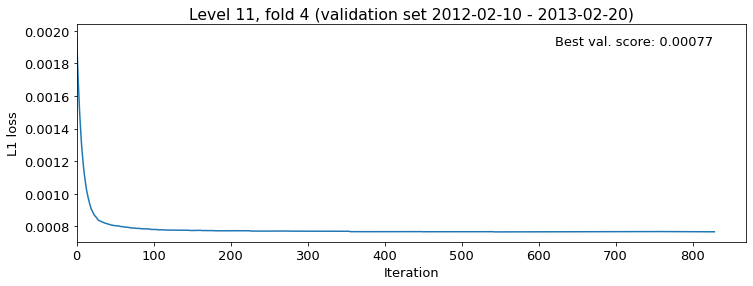

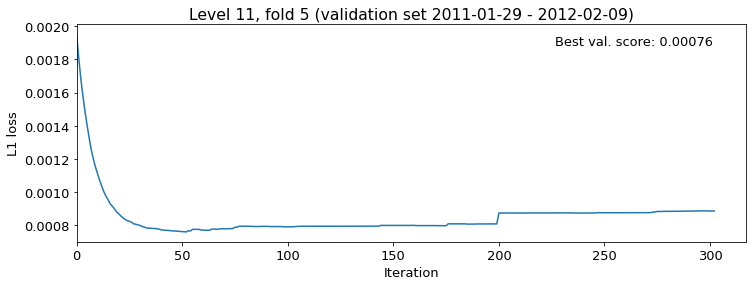

In [22]:
result_list = []
title_list = []

for level in range(1, 1+11):
    print("========== Starting level {} ==========".format(level))
    for fold in range(1, 1+5):
        print("== Starting fold {} ==".format(fold))
        # train
        model, evals_result, val = train_lightgbm_model(level, fold=fold, params=params, model_dir=model_dir,
                                                        augment_events=augment_events, 
                                                        early_stopping_rounds=early_stopping_rounds)
        
        # save results
        result_list.append(evals_result)
        title_list.append("Level {}, fold {} (validation set {} - {})".format(
            level, fold, str(val.date.min().date()), str(val.date.max().date())))
        
        # clear and plot
        clear_output()
        plot_result_list(result_list, title_list)

In [23]:
previous_best = {
    1: [0.0493934, 0.0298529, 0.0342514, 0.0344774, 0.0707565],
    2: [0.033977, 0.0261146, 0.0287358, 0.0289619, 0.0438592],
    3: [0.0273165, 0.0249012, 0.0249616, 0.0260428, 0.0298063],
    4: [0.0300114, 0.0204596, 0.0234199, 0.0235564, 0.0260425],
    5: [0.0202935, 0.0171001, 0.0192852, 0.0206354, 0.0266571],
    6: [0.0212708, 0.0183382, 0.0207929, 0.0219127, 0.0240263],
    7: [0.0166839, 0.0140424, 0.0159606, 0.016011, 0.0180554],
    8: [0.0197899, 0.0172478, 0.0187071, 0.0185251, 0.0212567],
    9: [0.01394, 0.0125006, 0.0132401, 0.0134896, 0.0144315],
    10: [0.00217599, 0.00200835, 0.00189426, 0.00164164, 0.00174878],
    11: [0.00103867, 0.000915226, 0.000869235, 0.000767116, 0.000757926],
    12: [0.000628875, 0.00053677, 0.000496496, 0.000429819, 0.000389586],
}

In [25]:
new_best = {level: [] for level in range(1, 11+1)}
ctr = 0

for level in range(1, 11+1):
    for fold in range(1, 5+1):
        score = result_list[ctr]['valid_0']['l1']
        best_score = min(score)
        new_best[level].append(best_score)
        ctr += 1

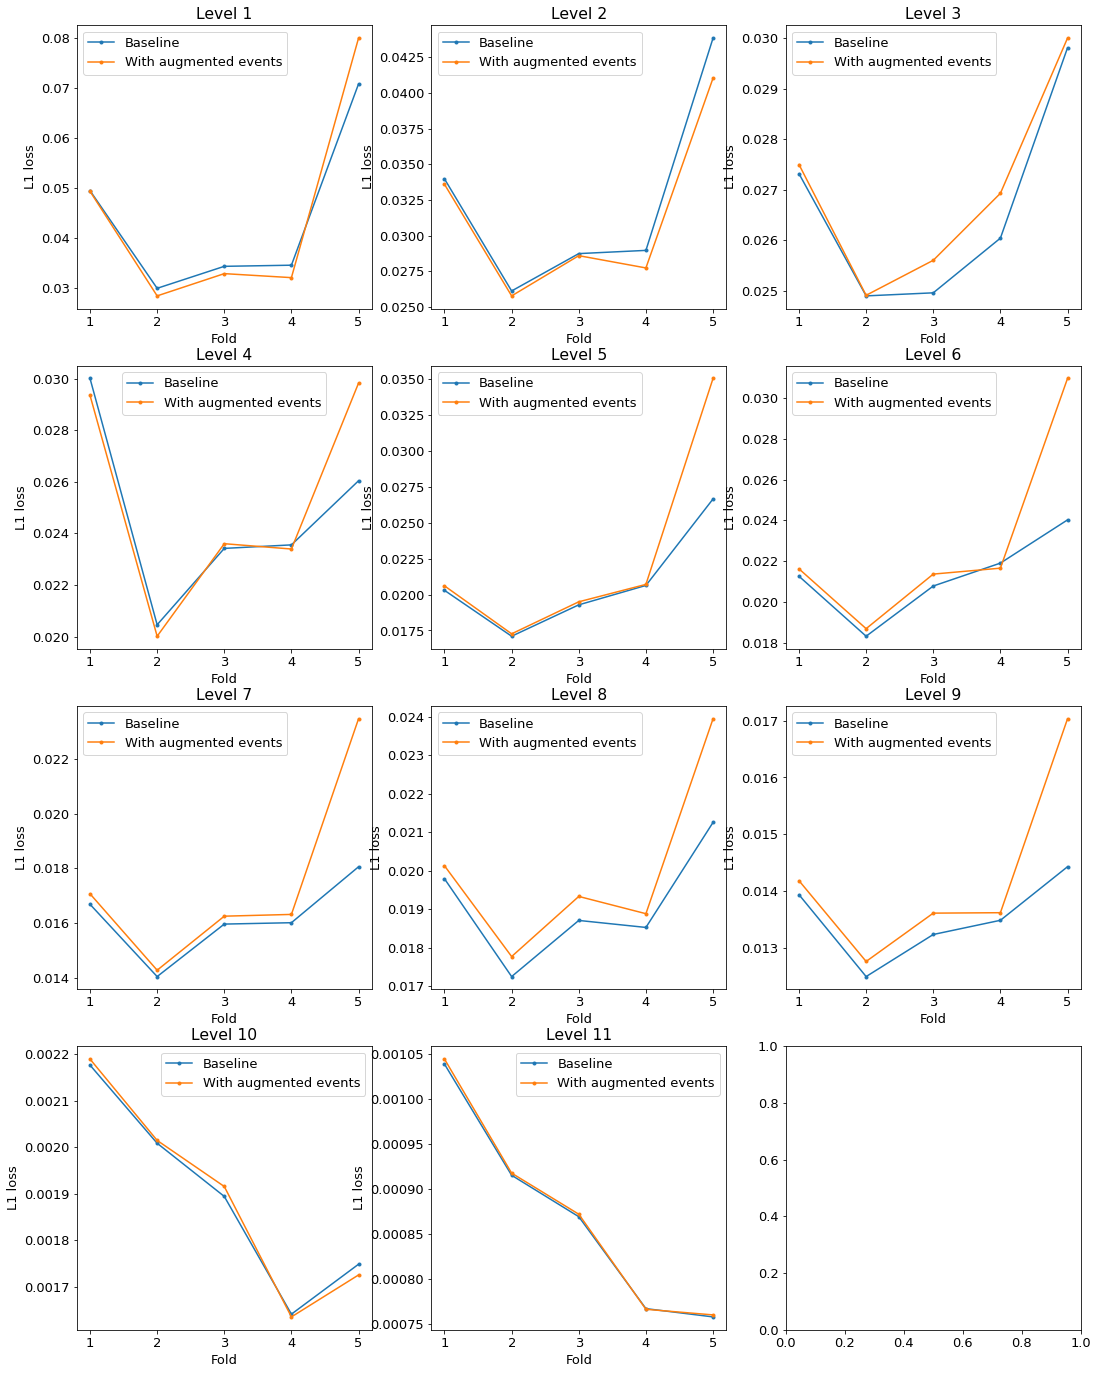

In [26]:
def plot_lgb_performances(previous_best, new_best):
    levels = list(new_best.keys())
    nrows = int(np.ceil(len(levels)/3))
    f, axes = plt.subplots(nrows, 3, figsize=(18, nrows*6))
    
    for level, ax in zip(levels, np.ravel(axes)):
        score_prev = previous_best[level]
        score_new = new_best[level]
        x = range(1, 5+1)
        ax.plot(x, score_prev, '.-', label="Baseline")
        ax.plot(x, score_new, '.-', label="With augmented events")
        ax.legend()
        ax.set_xlabel("Fold")
        ax.set_ylabel("L1 loss")
        ax.set_title("Level {}".format(level))
    
    plt.show()

plot_lgb_performances(previous_best, new_best)

In [33]:
m1 = np.mean([np.mean(m) for m in previous_best.values()])
m2 = np.mean([np.mean(m) for m in new_best.values()])
print("Previous mean best L1 loss: {:.4f}".format(m1))
print("Previous mean best L1 loss: {:.4f}".format(m2))
print("Change: {:.2%}".format((m2-m1)/m1))

Previous mean best L1 loss: 0.0185
Previous mean best L1 loss: 0.0207
Change: 12.32%
